# Executive Summary
Kiva is an international, nonprofit organization whose ultimate mission is to alleviate poverty through crowdfunded loans. Loans through Kiva are requested for a myriad of reasons including: to start or grow a business, to go to school, to access clean water or to simply repair a rickshaw to maintain a living. To date, Kiva has reached 2.6 million borrowers in 86 countries through 1.7 million lenders.   

To impact the greatest number of people, Kiva has established two working models: direct loans and partner loans. Direct loans are currently only available to U.S. residents and are made through Paypal. Partner loans, on the other hand, are adminstered through a Field Partner (local nonprofits or lending institutions) who will collect some interest. As mentioned by the Kiva Impact Team in the ongoing discussions, we are mostly concerned with the partner loans as they occur in rural and developing markets where interest in understanding borrower behavior is high. 

The partner loans follow a simple protocol:

1. The prospective borrower will meet with a Field Partner and apply for a loan;

2. The Field Partner will approve the loan and disberse funds right then;

3. The Field Partner will then upload loan details to Kiva's system; 

4. Kiva's pre-established network of volunteers will then edit and translate details as appropriate before going live on the website.

5. Once live, lenders will fund the loan in $25 increments until the amount is reached; 

6. When fundraising is complete, Kiva sends money to Field Partners;

7. Simultanesouly, borrowers (who received the money upfront before fundraising) are on a repayment schedule, often based on ability to pay. Payments are made to the Field Partner who sends the money back to the lenders through their Kiva accounts. 

8. At this point, lenders can choose to either fund another loan, donate the money to Kiva or withdraw theri money completely. 

According to Kiva's website, 100% of every dollar loaned on Kiva will go to backing loans. Kiva is otherwsie supported by optional donations, grants and/or sponsers. 

As funding in rural and developing markets can be unstable, Kiva is intent on learning more about borrower behavior. Understanding the psychology and circumstance around these microfinanced loans will better help Kiva set investment priorities, help inform prospective lenders, and better understand communities to hopefully then expand to other countries in need. 

Today, our goal is to use data from Kiva's active loans along with some external data sources to ultimately best estimate the welfare level of borrowers based on shared economic and demographic characteristics. The idea is to connect features of a loan or product to poverty mapping datasets in as granular manner as possible. 

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

In [ ]:
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

In [ ]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_colwidth', 999)

# Load Datasets Into SQL Database

In [370]:
def csv_into_sql(csv_file, sql_table, conn):
    try:
        conn.cursor().execute("SELECT 1 FROM %s LIMIT 1" % sql_table)
    except sqlite3.OperationalError:
        data = pd.read_csv(csv_file)
        data.columns = [col.lower().replace(' ', '_') for col in data.columns]
        data.to_sql(sql_table, conn, if_exists="replace")

In [349]:
#Create connection to sql database
conn = sqlite3.connect("kiva.sqlite")

In [350]:
#Load kiva_loans csv into SQL Database if it does not exist
csv_into_sql('kiva_loans.csv', 'kiva_loans', conn)

In [351]:
#Load kiva_mpi_region_locations csv into SQL Database if it does not exist
csv_into_sql('kiva_mpi_region_locations.csv', 'kiva_locations', conn)

In [352]:
#Load loan_themes_by_region csv into SQL Database if it does not exist
csv_into_sql('loan_themes_by_region.csv', 'loan_theme_region', conn)

In [353]:
#Load loan_themes_by_region csv into SQL Database if it does not exist
csv_into_sql('loan_theme_ids.csv', 'loan_theme', conn)

# Quick Loan Statistics in Kiva Crowdfunded Countries

In [340]:
loan_data = pd.read_sql_query(
    """
    SELECT SUM(loan_amount) AS total_loan_amount, COUNT(kiva_loans.country) AS num_loans, \
        AVG(loan_amount) AS average, kiva_loans.country AS country, kiva_locations.ISO
    FROM kiva_loans
    INNER JOIN kiva_locations ON kiva_loans.country = kiva_locations.country
    WHERE kiva_loans.country IS NOT NULL
    GROUP BY kiva_loans.country
    ORDER BY num_loans ASC
    """, 
    conn
)
loan_data

,total_loan_amount,num_loans,average,country,ISO
0,9250.0,4,2312.500000,Vanuatu,VUT
1,180000.0,12,15000.000000,Mauritania,MRT
2,380000.0,38,10000.000000,Bhutan,BTN
3,476000.0,68,7000.000000,Afghanistan,AFG
4,225875.0,75,3011.666667,Somalia,SOM
5,420875.0,104,4046.875000,Namibia,NAM
6,426100.0,180,2367.222222,Thailand,THA
7,574025.0,378,1518.584656,South Africa,ZAF
8,1141575.0,402,2839.738806,China,CHN
9,798175.0,875,912.200000,Belize,BLZ


In [336]:
loan_data['num_loans_string'] = loan_data['num_loans'].map(lambda x: "{:,}".format(x))

loan_data['avg_loans_string'] = loan_data['average'].map(lambda x: "${:,}".format(round(x, 2)))

loan_data['total_loans_string'] = loan_data['total_loan_amount'].map(lambda x: "${:,}".format(x))

In [339]:
loan_data['text'] = loan_data['country'] + '<br>' + \
                                    'Number of Loans:' + ' ' + loan_data['num_loans_string']+ '<br>' + \
                                    'Average Loan:' + ' ' + loan_data['avg_loans_string']

data = [ dict(
        type = 'choropleth',
        locations = loan_data['ISO'],
        z = loan_data['total_loan_amount'],
        text = loan_data['text'], 
        #colorscale = 'Blues',
        colorscale = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']],

        reversescale = False,
        showlegend = True,
        colorbar = dict(
            #autotick = False,
            tick0= 0,
            tickprefix = '$',
            title = 'Total Funded <br>Amount (USD)'),
      ) ]

layout = dict(
    title = 'Total Loan Amounts in <br>Kiva Crowdfunded Countries',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False)

# Kiva Loan Data Prep & Visualization

When a loan process is intiated, the loan is given a unique id number. This number was used to index the kiva_loans.csv dataset provided by the orgnizers and is therefore unique to each row. 

In [331]:
#Read in the data
kiva_loans = pd.read_sql_query("select * from kiva_loans;", conn)
kiva_loans.head()

,index,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,None,female,irregular,2014-01-01
1,1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used in their business.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,None,"female, female",irregular,2014-01-01
2,2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another one to rent out as a source of income,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variety of new embroidery materials.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,None,female,irregular,2014-01-01
4,4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,None,female,monthly,2014-01-01


In [154]:
kiva_loans['funded_amount'].describe()

count    671205.000000
mean        785.995061
std        1130.398941
min           0.000000
25%         250.000000
50%         450.000000
75%         900.000000
max      100000.000000
Name: funded_amount, dtype: float64

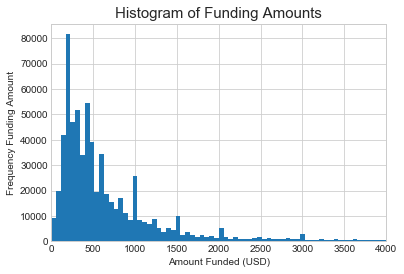

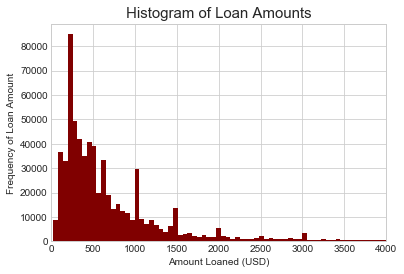

In [155]:
sns.set_style("whitegrid")
plt.figure()
kiva_loans['funded_amount'].hist(bins = 1750)
plt.xlim(0,4000)
plt.xlabel("Amount Funded (USD)", fontsize = 10)
plt.ylabel("Frequency Funding Amount", fontsize =10)
plt.title("Histogram of Funding Amounts", fontsize = 15)

plt.figure()
kiva_loans['loan_amount'].hist(bins = 1750, color = 'maroon')
plt.xlim(0,4000)
plt.xlabel("Amount Loaned (USD)", fontsize = 10)
plt.ylabel("Frequency of Loan Amount", fontsize =10)
plt.title("Histogram of Loan Amounts", fontsize = 15);

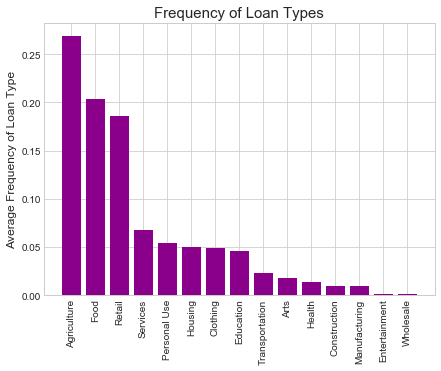

In [157]:
sns.set_style('whitegrid')
plt.figure(figsize = (7,5))
plt.bar(left = np.arange(len(kiva_loans['sector'].value_counts(normalize = True))), \
        height = kiva_loans['sector'].value_counts(normalize = True), color = 'darkmagenta')
plt.xticks(np.arange(15), list(kiva_loans['sector'].value_counts(normalize = True).keys()), rotation = 90)
plt.ylabel("Average Frequency of Loan Type", fontsize = 12)
plt.title("Frequency of Loan Types", fontsize = 15);

In [158]:
#Create columns with singular male, female or both label
gender_list = []
for row in kiva_loans['borrower_genders']:
    if type(row) == float:
        gender_list.append('unknown')
    elif (' male' in row) & (' female' in row): 
        gender_list.append('both')
    elif 'female' in row:
        gender_list.append('female')
    elif 'male' in row:
        gender_list.append('male')   

In [159]:
kiva_loans['gender'] = gender_list

In [160]:
#Create column for borrowers
borrower_num = []
for row in kiva_loans['borrower_genders']:
    if type(row) == float:
        borrower_num.append('unknown')
    else:
        borrower_num.append(len(row.split(' ')))

In [161]:
kiva_loans['number_of_borrowers'] = borrower_num

In [162]:
kiva_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,gender,number_of_borrowers
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01,female,1
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used in their business.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01,female,2
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another one to rent out as a source of income,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,female,1
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variety of new embroidery materials.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01,female,1
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01,female,1


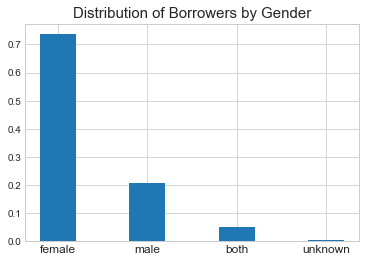

In [207]:
plt.bar(left = np.arange(len(kiva_loans['gender'].value_counts(normalize = True))), \
        height = kiva_loans['gender'].value_counts(normalize = True), width = 0.4)
plt.xticks(np.arange(4), list(kiva_loans['gender'].value_counts(normalize = True).keys()), fontsize = 12)
plt.title("Distribution of Borrowers by Gender", fontsize = 15);

In [212]:
kiva_loans['repayment_interval'].value_counts(normalize = True)

monthly      0.510600
irregular    0.383129
bullet       0.105375
weekly       0.000897
Name: repayment_interval, dtype: float64

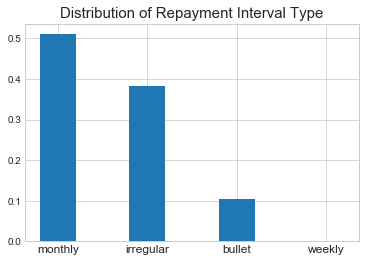

In [210]:
#Plot repayment interval
plt.bar(left = np.arange(len(kiva_loans['repayment_interval'].value_counts(normalize = True))), \
        height = kiva_loans['repayment_interval'].value_counts(normalize = True), width = 0.4)
plt.xticks(np.arange(4), list(kiva_loans['repayment_interval'].value_counts(normalize = True).keys()), fontsize = 12)
plt.title("Distribution of Repayment Interval Type", fontsize = 15);

In [311]:
#Label the quarter the loan was asked for
quarter = []
for row in kiva_loans['date']: 
    month = int(row.split('-')[1])
    
    if (month >= 1) & (month <= 3):
        quarter.append('1')
    
    elif (month >= 4) & (month <= 6):
        quarter.append('2')
        
    elif (month >= 7) & (month <= 9):
        quarter.append('3')
    
    elif (month >= 10) & (month <= 12):
        quarter.append('4')
        

In [312]:
kiva_loans['quarter_loan_posted'] = quarter

In [314]:
kiva_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,gender,number_of_borrowers,quarter_loan_posted
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01,female,1,1
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used in their business.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01,female,2,1
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another one to rent out as a source of income,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,female,1,1
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variety of new embroidery materials.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01,female,1,1
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01,female,1,1


In [163]:
#Calculate how many loans were fulfilled
#Calculate how many loans were paid back
#Aggregate payment type
#Calculate post time
#Find conversion rate
#If done over a span of years, find inflation rate
#Label quarter loan was asked for/fulfilled

In [88]:
#Datasets to bring in (prob from World Bank): 
#poverty index
#education levels
#male/female populatino ratios
#economic situation

In [268]:
kiva_loc = pd.read_csv("kiva_mpi_region_locations.csv")
kiva_loc.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [233]:
#Unique by id for loan
loan_theme_id = pd.read_csv("loan_theme_ids.csv")
loan_theme_id.head()

,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.0
1,640322,a1050000000skGl,General,151.0
2,641006,a1050000002X1ij,Higher Education,160.0
3,641019,a1050000002X1ij,Higher Education,160.0
4,641594,a1050000002VbsW,Subsistence Agriculture,336.0
